In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Psi Confusion Matrix

In [14]:
original_psi= pd.read_csv('/work/Genometechlab/neda/mod-ivt/full_read/12_16_24_mod_IVT_dorado_0.8.1_pseU_emit-moves_threshold_0_aligned_sorted_with_tags_filtered_valid_modkit_header_psi.tsv', sep='\t')

ref_names_ivt = ['psU_PhMh_IVT', 'psU_PhMl_IVT', 'psU_PlMh_IVT']
ref_names = ['psU_PhMh', 'psU_PhMl', 'psU_PlMh']

psi_filtered = original_psi[(original_psi['end_position'] == 61) & (original_psi['chrom'].isin(ref_names))]
psi_ivt_filtered = original_psi[(original_psi['end_position'] == 64) & (original_psi['chrom'].isin(ref_names_ivt))]

final_df = pd.concat([psi_filtered, psi_ivt_filtered], ignore_index=True)
final_df

,chrom,start_position,end_position,modified_base_code,score,strand,start_position_compat,end_position_compat,color,Nvalid_cov,fraction_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,psU_PhMh,60,61,17802,1252494,+,60,61,"255,0,0",1252494,97.83,1225313,27181,0,112969,49649,821377,0
1,psU_PhMl,60,61,17802,1499671,+,60,61,"255,0,0",1499671,95.75,1435885,63786,0,195708,49581,106894,0
2,psU_PlMh,60,61,17802,908525,+,60,61,"255,0,0",908525,94.42,857802,50723,0,90622,60200,281210,0
3,psU_PhMh_IVT,63,64,17802,326626,+,63,64,"255,0,0",326626,1.04,3396,323230,0,2716,32219,1289,0
4,psU_PhMl_IVT,63,64,17802,461138,+,63,64,"255,0,0",461138,1.54,7088,454050,0,14277,19095,1422,0
5,psU_PlMh_IVT,63,64,17802,863316,+,63,64,"255,0,0",863316,1.41,12183,851133,0,12040,64133,7569,0


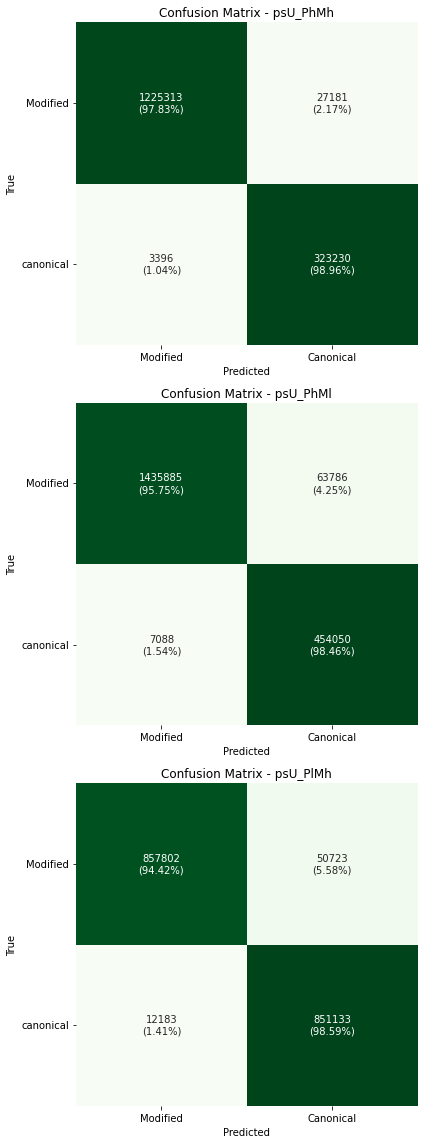

In [9]:
data = {
    "chrom": ['psU_PhMh', 'psU_PhMl', 'psU_PlMh', 'psU_PhMh_IVT', 'psU_PhMl_IVT', 'psU_PlMh_IVT'],
    "start_position": [60, 60, 60, 63, 63, 63],
    "end_position": [61, 61, 61, 64, 64, 64],
    "Nmod": [1225313, 1435885, 857802, 3396, 7088, 12183], 
    "Ncanonical": [27181, 63786, 50723, 323230, 454050, 851133], 
}

df = pd.DataFrame(data)

ref_pairs = [
    ('psU_PhMh', 'psU_PhMh_IVT'),
    ('psU_PhMl', 'psU_PhMl_IVT'),
    ('psU_PlMh', 'psU_PlMh_IVT')
]

confusion_matrices = []

for ref1, ref2 in ref_pairs:
    site1 = df[df['chrom'] == ref1].iloc[0]
    site2 = df[df['chrom'] == ref2].iloc[0]

    TP = site1['Nmod'] # mod in mod
    TN = site2['Ncanonical'] # canon in ivt
    FP = site2['Nmod'] # mod in ivt
    FN = site1['Ncanonical'] # canon in mod

    confusion_matrices.append({
        "Site": ref1,
        "Confusion Matrix": np.array([[TP, FN], [FP, TN]])
    })

fig, axes = plt.subplots(len(confusion_matrices), 1, figsize=(6, 16))

for i, matrix_data in enumerate(confusion_matrices):
    site = matrix_data["Site"]
    cm = matrix_data["Confusion Matrix"]
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    annotations = [[f"{cm[i, j]}\n({cm_percentage[i, j]:.2f}%)" for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Greens', cbar=False, ax=axes[i]) # YlGn_r
    axes[i].set_title(f"Confusion Matrix - {site}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_xticks([0.5, 1.5])
    axes[i].set_yticks([0.5, 1.5])
    axes[i].set_xticklabels(["Modified", "Canonical"])
    axes[i].set_yticklabels(["Modified", "canonical"], rotation=0)

plt.tight_layout()
plt.show()

### Performance Metrics

In [10]:
data = {
    "chrom": ['psU_PhMh', 'psU_PhMl', 'psU_PlMh', 'psU_PhMh_IVT', 'psU_PhMl_IVT', 'psU_PlMh_IVT'],
    "Nmod": [1225313, 1435885, 857802, 3396, 7088, 12183], 
    "Ncanonical": [27181, 63786, 50723, 323230, 454050, 851133],
}

df = pd.DataFrame(data)

ref_pairs = [
    ('psU_PhMh', 'psU_PhMh_IVT'),
    ('psU_PhMl', 'psU_PhMl_IVT'),
    ('psU_PlMh', 'psU_PlMh_IVT')]

results = []

for ref1, ref2 in ref_pairs:
    site1 = df[df['chrom'] == ref1].iloc[0]
    site2 = df[df['chrom'] == ref2].iloc[0]

    TP = site1['Nmod']
    TN = site2['Ncanonical']
    FP = site2['Nmod']
    FN = site1['Ncanonical']

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1_score = 2 * (precision * recall) / (precision + recall)

    results.append({"Site": ref1, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1_score})

results_df = pd.DataFrame(results)

print(results_df)

       Site  Accuracy  Precision    Recall  F1-Score
0  psU_PhMh  0.980637   0.997236  0.978298  0.987677
1  psU_PhMl  0.963855   0.995088  0.957467  0.975915
2  psU_PlMh  0.964497   0.985996  0.944170  0.964630


## m6A Confusion matrix

In [11]:
original_m6a= pd.read_csv('/work/Genometechlab/neda/mod-ivt/12_16_24_mod_IVT_dorado_0.8.1_ino_m6a_emit-moves_threshold_0_aligned_with_mod_tags_sorted_filtered_valid_reads_modkit_header_m6a_new.tsv', sep='\t')

ref_names_ivt = ['Dorado_High_m6Anet_Low_IVT', 'm6Anet_High_Dorado_Low_IVT', 'Both_High_IVT']
ref_names = ['Dorado_High_m6Anet_Low', 'm6Anet_High_Dorado_Low', 'Both_High']

m6a_filtered = original_m6a[(original_m6a['end_position'] == 61) & (original_m6a['chrom'].isin(ref_names))]
m6a_ivt_filtered = original_m6a[(original_m6a['end_position'] == 64) & (original_m6a['chrom'].isin(ref_names_ivt))]

final_df = pd.concat([m6a_filtered, m6a_ivt_filtered], ignore_index=True)

final_df= final_df[final_df['modified_base_code'] == "a"]
final_df

,chrom,start_position,end_position,modified_base_code,score,strand,start_position_compat,end_position_compat,color,Nvalid_cov,fraction_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocall
0,Dorado_High_m6Anet_Low,60,61,a,1937808,+,60,61,"255,0,0",1937808,93.12,1804583,132571,654,51660,155521,10906,0
2,m6Anet_High_Dorado_Low,60,61,a,2098876,+,60,61,"255,0,0",2098876,98.67,2070975,27411,490,32570,36979,5849,0
4,Both_High,60,61,a,1849129,+,60,61,"255,0,0",1849129,96.92,1792142,56692,295,28582,50257,20348,0
6,Both_High_IVT,63,64,a,1105128,+,63,64,"255,0,0",1105128,2.19,24155,1080715,258,4995,44492,1692,0
8,Dorado_High_m6Anet_Low_IVT,63,64,a,762965,+,63,64,"255,0,0",762965,0.83,6336,756551,78,11921,19722,1651,0
10,m6Anet_High_Dorado_Low_IVT,63,64,a,162037,+,63,64,"255,0,0",162037,1.46,2362,159633,42,1401,6040,242,0


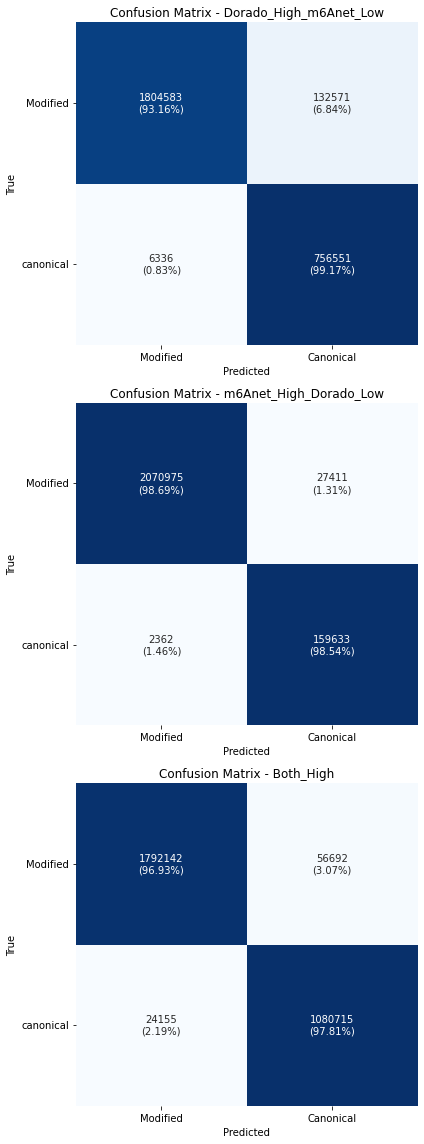

In [12]:
data = {"chrom": ["Dorado_High_m6Anet_Low", "m6Anet_High_Dorado_Low", "Both_High","Both_High_IVT", "Dorado_High_m6Anet_Low_IVT", "m6Anet_High_Dorado_Low_IVT"],
    "Nmod": [1804583, 2070975, 1792142, 24155, 6336, 2362],
    "Ncanonical": [132571, 27411, 56692, 1080715, 756551, 159633]}
df = pd.DataFrame(data)

ref_pairs = [
    ("Dorado_High_m6Anet_Low", "Dorado_High_m6Anet_Low_IVT"),
    ("m6Anet_High_Dorado_Low", "m6Anet_High_Dorado_Low_IVT"),
    ("Both_High", "Both_High_IVT")]

confusion_matrices = []

for ref1, ref2 in ref_pairs:
    site1 = df[df['chrom'] == ref1].iloc[0]
    site2 = df[df['chrom'] == ref2].iloc[0]

    TP = site1['Nmod'] # mod in mod
    TN = site2['Ncanonical'] # canon in ivt
    FP = site2['Nmod'] # mod in ivt
    FN = site1['Ncanonical'] # canon in mod

    confusion_matrices.append({
        "Site": ref1,
        "Confusion Matrix": np.array([[TP, FN], [FP, TN]])
    })

fig, axes = plt.subplots(len(confusion_matrices), 1, figsize=(6, 16))

for i, matrix_data in enumerate(confusion_matrices):
    site = matrix_data["Site"]
    cm = matrix_data["Confusion Matrix"]
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    annotations = [[f"{cm[i, j]}\n({cm_percentage[i, j]:.2f}%)" for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Blues', cbar=False, ax=axes[i]) # RdBu_r
    axes[i].set_title(f"Confusion Matrix - {site}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_xticks([0.5, 1.5])
    axes[i].set_yticks([0.5, 1.5])
    axes[i].set_xticklabels(["Modified", "Canonical"])
    axes[i].set_yticklabels(["Modified", "canonical"], rotation=0)

plt.tight_layout()
plt.show()

In [13]:
data = {"chrom": ["Dorado_High_m6Anet_Low", "m6Anet_High_Dorado_Low", "Both_High","Both_High_IVT", "Dorado_High_m6Anet_Low_IVT", "m6Anet_High_Dorado_Low_IVT"],
    "Nmod": [1804583, 2070975, 1792142, 24155, 6336, 2362],
    "Ncanonical": [132571, 27411, 56692, 1080715, 756551, 159633]}

df = pd.DataFrame(data)

ref_pairs = [
    ("Dorado_High_m6Anet_Low", "Dorado_High_m6Anet_Low_IVT"),
    ("m6Anet_High_Dorado_Low", "m6Anet_High_Dorado_Low_IVT"),
    ("Both_High", "Both_High_IVT")]

results = []
for ref1, ref2 in ref_pairs:
    site1 = df[df['chrom'] == ref1].iloc[0]
    site2 = df[df['chrom'] == ref2].iloc[0]

    TP = site1['Nmod']
    TN = site2['Ncanonical']
    FP = site2['Nmod']
    FN = site1['Ncanonical']

    accuracy = (TP + TN) / (TP + TN + FP + FN)    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    results.append({"Site": ref1, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1_score})

results_df = pd.DataFrame(results)
print(results_df)

                     Site  Accuracy  Precision    Recall  F1-Score
0  Dorado_High_m6Anet_Low  0.948554   0.996501  0.931564  0.962939
1  m6Anet_High_Dorado_Low  0.986828   0.998861  0.986937  0.992863
2               Both_High  0.972629   0.986701  0.969336  0.977942
